# READ ME ❗❗

Some advices on implementing new model ◀

> 1. This is designed for image based classification/ bounding box Models, if you want to try other models, can take the reference on the full pipeline of this.


> 2. If you keep encountering build errors (package compatibility, outdated dependencies) when implementing a new model, its often not worth the effort. Another model (DefNet from GitHub) took me 1-2 days to build and still had errors, leading to even more issues. In contrast, I implemented this PyTorch model from scratch to training in just 4-5 hours.

Things to take note in this model ✅

> 1. Pay attention to dataset annotations, as they impact data augmentation and preprocessing. Since our dataset uses bounding boxes, resizing from 400x700 to 224x224 requires scaling the bounding box coordinates accordingly. Otherwise, training on 224x224 images with unscaled coordinates (e.g., 312, 512, 377, 600) would be illogical. Could refer Some parts in Class CustomCoCODataset & Class BboxAugmentation . **torchvision.transforms library (we learnt in class) only do image transforms but not bbox.**



> 2.  In Class **load_data** ,I computed the mean and standard deviation for dataset normalization instead of using the predefined normalization values from a pretrained model's dataset.( Which can be found on internet) because we want to make our model customized to the dataset.






In [ ]:
########## This section is designed to be modified according to needs#########




########## This section is designed to be modified according to needs#########

# Load Dataset Into your notebook

In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="HEIVkitsKN5GrtOiJhcI")
project = rf.workspace("five-defects").project("yes_defects")
version = project.version(3)
dataset = version.download("coco")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 83.0 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to yes_defects-3 in coco:: 100%|██████████| 5069/5069 [00:01<00:00, 4388.21it/s]


# 1. Import dataset from Roboflow where we can just straight download code snippet and integrate

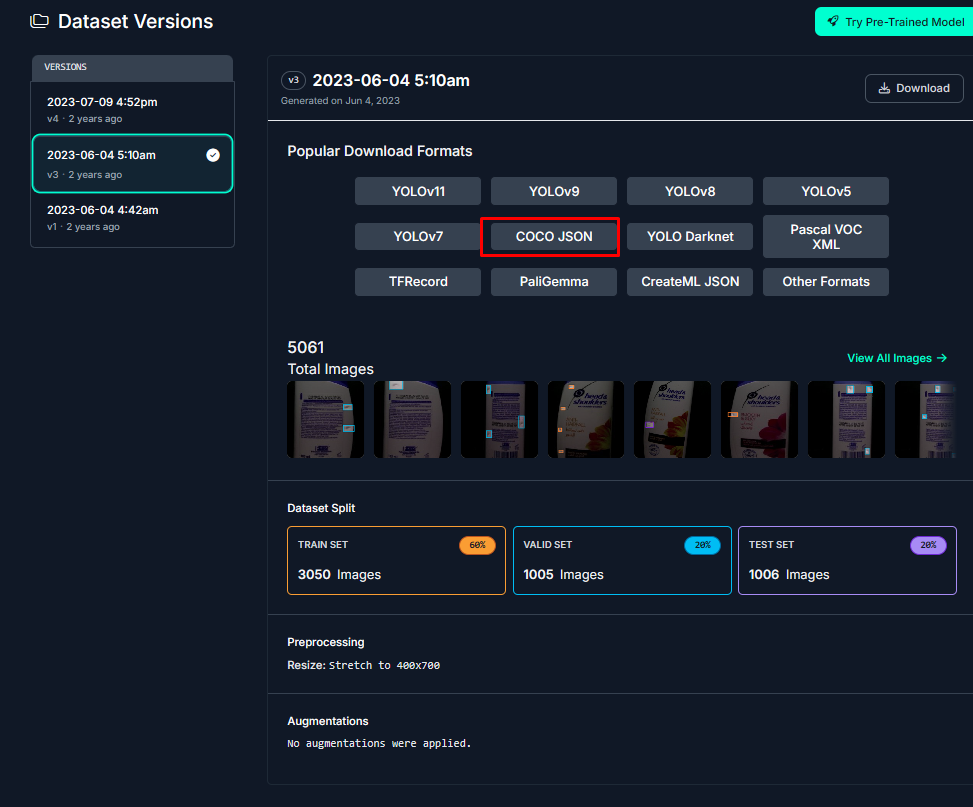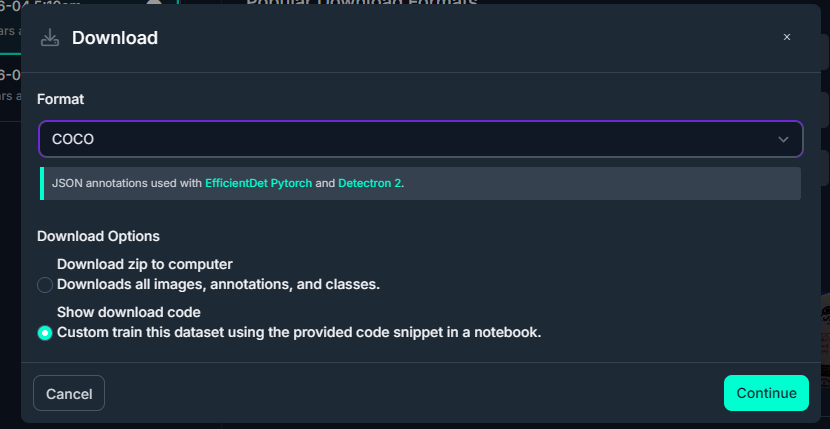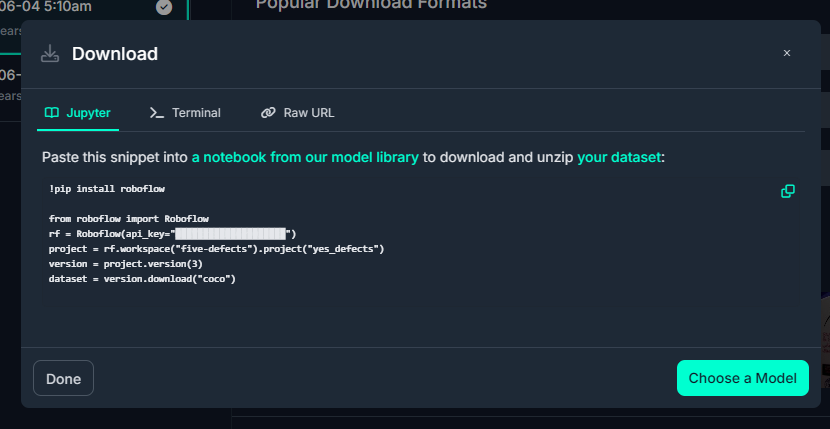

# 2. Setting Up Dataset

## Defining Dataset Class (Resizing, Reduce Ratio)

In [2]:
import torch
import torchvision.transforms as T
from torchvision.transforms import functional as F
from pycocotools.coco import COCO
import os
import random
import numpy as np
from PIL import Image, ImageFilter

class CustomCocoDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation_file, transforms=None, img_size=None, reduce_ratio=None):
        """
        Args:
            root (str): Path to the image directory.
            annotation_file (str): Path to the COCO JSON annotation file.
            transforms (callable, optional): Transformations applied to images.
            img_size (tuple, optional): Target image size (width, height).
            reduce_ratio (float, optional): Ratio to reduce the dataset. If None, no reduction.
        """

        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation_file)
        self.ids = list(self.coco.imgs.keys())
        self.img_size = img_size  # (width, height), or None for no resizing

        # Reduce dataset by ratio if specified
        if reduce_ratio:
            self.reduce_dataset(reduce_ratio)

    def reduce_dataset(self, ratio):
        """
        Reduces the dataset size by the specified ratio.
        Args:
            ratio (float): Ratio to reduce the dataset, e.g., 0.5 means keep half the data.
        """
        num_samples = len(self.ids)
        num_samples_to_keep = int(num_samples * ratio)
        self.ids = random.sample(self.ids, num_samples_to_keep)
        print(f"Reduced dataset to {num_samples_to_keep} samples (from {num_samples}).")


    def __getitem__(self, index):
        img_id = self.ids[index]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        annotations = self.coco.loadAnns(ann_ids)

        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.root, img_info["file_name"])
        image = Image.open(img_path).convert("RGB")


        # Original image size
        orig_w, orig_h = img_info["width"], img_info["height"]

        # Resize image if needed
        if self.img_size:
            new_w, new_h = self.img_size
            image = F.resize(image, (new_h, new_w))
            scale_x = new_w / orig_w
            scale_y = new_h / orig_h
        else:
            scale_x, scale_y = 1.0, 1.0

        if self.transforms:
            image = self.transforms(image)


        # Scale bounding boxes accordingly
        boxes = []
        labels = []
        for ann in annotations:
            x, y, w, h = ann["bbox"]
            xmin = x * scale_x
            ymin = y * scale_y
            xmax = (x + w) * scale_x
            ymax = (y + h) * scale_y

            # Ensure valid bounding boxes
            if xmax > xmin and ymax > ymin:
                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(ann["category_id"])
            else:
                print(f"Warning: Invalid bbox {xmin, ymin, xmax, ymax} removed.")

        # Convert to tensors
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels, "image_id": torch.tensor([img_id])}
        return image, target

    def __len__(self):
        return len(self.ids)


## Defining Data Augmentation Class (need to transform both image and bbox, torchvision.transform only transform image)

In [3]:
class BboxAugmentation:
    def __init__(self,
                 flip_prob=0.5,
                 max_shift=0.1,
                 max_rotate=15,
                 brightness=None,
                 contrast=None):
        self.flip_prob = flip_prob
        self.max_shift = max_shift  # Fraction of image size
        self.max_rotate = max_rotate  # Degrees
        self.brightness = brightness
        self.contrast = contrast
        self._is_tensor = False  # Track if input is tensor

    def __call__(self, image, target):
        # Track if input is tensor
        self._is_tensor = isinstance(image, torch.Tensor)

        # Convert tensor to PIL if needed
        if self._is_tensor:
            image = F.to_pil_image(image)

        # Get image dimensions
        w, h = image.size

        # Apply augmentations in sequence
        if random.random() < self.flip_prob:
            image, target = self.horizontal_flip(image, target)

        if random.random() < 0.5:
            shift_x = random.uniform(-self.max_shift, self.max_shift) * w
            shift_y = random.uniform(-self.max_shift, self.max_shift) * h
            image, target = self.shift(image, target, shift_x, shift_y)

        if random.random() < 0.5:
            angle = random.uniform(-self.max_rotate, self.max_rotate)
            image, target = self.rotate(image, target, angle)

        # Convert back to tensor if original was tensor
        if self._is_tensor:
            image = F.to_tensor(image)

        return image, target

    def horizontal_flip(self, image, target):
        image = F.hflip(image)
        w = image.width

        # Flip bounding boxes
        boxes = target["boxes"].clone()
        boxes[:, [0, 2]] = w - boxes[:, [2, 0]]  # x1 = w - x2, x2 = w - x1
        target["boxes"] = boxes

        return image, target

    def shift(self, image, target, shift_x, shift_y):
        # Apply affine transformation
        image = F.affine(
            image,
            angle=0,
            translate=(int(shift_x), int(shift_y)),
            scale=1.0,
            shear=0
        )

        # Shift bounding boxes
        boxes = target["boxes"].clone()
        boxes[:, [0, 2]] += shift_x  # x coordinates
        boxes[:, [1, 3]] += shift_y  # y coordinates

        # Clip boxes to image boundaries
        boxes[:, 0::2].clamp_(min=0, max=image.width)
        boxes[:, 1::2].clamp_(min=0, max=image.height)

        # Remove boxes that became invalid
        valid_boxes = (boxes[:, 2] > boxes[:, 0]) & (boxes[:, 3] > boxes[:, 1])
        target["boxes"] = boxes[valid_boxes]
        target["labels"] = target["labels"][valid_boxes]

        return image, target

    def rotate(self, image, target, angle):
        # Convert to tensor to get dimensions
        img_tensor = F.to_tensor(image)
        h, w = img_tensor.shape[-2:]

        # Rotate image
        image = F.rotate(image, angle, expand=False)

        # Convert boxes to polygons, rotate, then back to boxes
        boxes = target["boxes"].clone()
        polygons = []
        for box in boxes:
            x1, y1, x2, y2 = box
            # Create polygon coordinates
            poly = np.array([
                [x1, y1], [x2, y1], [x2, y2], [x1, y2]
            ])
            polygons.append(poly)

        # Rotate polygons
        center = (w/2, h/2)
        rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated_polys = []
        for poly in polygons:
            # Add ones for homogeneous coordinates
            poly_homo = np.column_stack((poly, np.ones(4)))
            rotated_poly = np.dot(rot_mat, poly_homo.T).T
            rotated_polys.append(rotated_poly)

        # Convert back to boxes
        new_boxes = []
        for poly in rotated_polys:
            x_coords = poly[:, 0]
            y_coords = poly[:, 1]
            new_box = [
                max(0, min(x_coords)),
                max(0, min(y_coords)),
                min(w, max(x_coords)),
                min(h, max(y_coords))
            ]
            new_boxes.append(new_box)

        new_boxes = torch.tensor(new_boxes, dtype=torch.float32)

        # Filter invalid boxes
        valid_boxes = (new_boxes[:, 2] > new_boxes[:, 0]) & (new_boxes[:, 3] > new_boxes[:, 1])
        target["boxes"] = new_boxes[valid_boxes]
        target["labels"] = target["labels"][valid_boxes]

        return image, target

In [4]:
# Wrap your dataset with augmentation
class AugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, bbox_augment, transforms=None):
        self.dataset = dataset  # Original dataset
        self.bbox_augment = bbox_augment  # Augmentation class
        self.transforms = transforms  # Optional normalization transform

    def __getitem__(self, idx):
        image, target = self.dataset[idx]
        # Apply augmentation to the image and target
        augmented_image, augmented_target = self.bbox_augment(image, target)

        # Apply normalization if a transform is provided
        if self.transforms:
            augmented_image = self.transforms(augmented_image)

        return augmented_image, augmented_target

    def __len__(self):
        return len(self.dataset)


## Compute the Datasets Normalization value (mean and std for your dataset)

In [5]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as T
from tqdm import tqdm

##############CHANG TO YOUR PATH#################

root_dir = "/content/yes_defects-3"

##############CHANG TO YOUR PATH#################

train_dir = os.path.join(root_dir, "train")
valid_dir = os.path.join(root_dir, "valid")
test_dir = os.path.join(root_dir, "test")

train_json = os.path.join(train_dir, "_annotations.coco.json")
valid_json = os.path.join(valid_dir, "_annotations.coco.json")
test_json = os.path.join(test_dir, "_annotations.coco.json")

# 1. Create basic dataset with only ToTensor transform
temp_dataset = CustomCocoDataset(
    root=train_dir,
    annotation_file=train_json,
    transforms=T.ToTensor(),  # Only this transform
    img_size=None,  # Don't resize yet
    reduce_ratio=None
)

# 2. Compute stats directly
pixel_sum = torch.zeros(3)
pixel_sq_sum = torch.zeros(3)
num_pixels = 0

for img, _ in temp_dataset:  # Direct iteration (no DataLoader)
    pixel_sum += img.sum(dim=[1, 2])  # Sum over height and width
    pixel_sq_sum += (img**2).sum(dim=[1, 2])
    num_pixels += img.shape[1] * img.shape[2]

Calculatedmean = pixel_sum / num_pixels
Calculatedstd = (pixel_sq_sum / num_pixels - Calculatedmean**2).sqrt()

print(f"Mean: {Calculatedmean.tolist()}")
print(f"Std: {Calculatedstd.tolist()}")

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
Mean: [0.20383122563362122, 0.18635477125644684, 0.214472696185112]
Std: [0.24466532468795776, 0.2258015275001526, 0.24685510993003845]


## Data Augmentation + Loading into dataloader

In [6]:
batch_size=16
num_workers=2
pin_memory=True
collate_fn=lambda x: tuple(zip(*x))

# Now define actual transforms with computed values
transforms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=Calculatedmean, std=Calculatedstd)
])

def load_data(data_augmentation=False):

    if data_augmentation: #When data_augmentation is true
        original_dataset = CustomCocoDataset(
            root=train_dir,
            annotation_file=train_json,
            transforms=transforms,
            img_size=(224, 224),
            reduce_ratio=None
        )

        ##############Change the reduce ratio to control the amount of augmented data according to your needs. #########################
        Tobeaugmented_dataset = CustomCocoDataset(
            root=train_dir,
            annotation_file=train_json,
            transforms=None,
            img_size=(224, 224),
            reduce_ratio=0.5 ### which means reduce the input dataset by half
        )
        ##############Change the reduce ratio to control the amount of augmented data according to your needs.#########################

        # Create augmentation instance
        bbox_augment = BboxAugmentation(
            flip_prob=0.5,
            max_shift=0.1,
            max_rotate=15
        )

        augmented_dataset = AugmentedDataset(Tobeaugmented_dataset, bbox_augment, transforms=transforms)

        #merging Two datasets
        train_dataset = torch.utils.data.ConcatDataset([original_dataset,augmented_dataset])

    else: #when Data augmentation is False
        train_dataset = CustomCocoDataset(
            root=train_dir,
            annotation_file=train_json,
            transforms=transforms,
            img_size=(224, 224),
            reduce_ratio=None
        )

    valid_dataset = CustomCocoDataset(
            root=valid_dir,
            annotation_file=valid_json,
            transforms=transforms,
            img_size=(224, 224),
            reduce_ratio=None
    )

    test_dataset = CustomCocoDataset(
            root=test_dir,
            annotation_file=test_json,
            transforms=transforms,
            img_size=(224, 224),
            reduce_ratio=None
    )

    #Put them into Data loader
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True ,
        num_workers=num_workers ,
        pin_memory=pin_memory,
        collate_fn=collate_fn
    )

    valid_loader = DataLoader(
        valid_dataset,
        batch_size=batch_size,
        shuffle=False ,
        num_workers=num_workers ,
        pin_memory=pin_memory,
        collate_fn=collate_fn
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False ,
        num_workers=num_workers ,
        pin_memory=pin_memory,
        collate_fn=collate_fn
    )

    return train_dataset , valid_dataset, test_dataset, train_loader, valid_loader , test_loader


### With Augmentation

In [7]:
train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader= load_data(data_augmentation=True)

train_images = len(train_loader.dataset)
valid_images = len(valid_loader.dataset)
test_images = len(test_loader.dataset)

print(f'Number of images in training set: {train_images}')
print(f'Number of images in validation set: {valid_images}')
print(f'Number of images in test set: {test_images}')

loading annotations into memory...
Done (t=0.41s)
creating index...
index created!
loading annotations into memory...
Done (t=0.11s)
creating index...
index created!
Reduced dataset to 1525 samples (from 3050).
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Number of images in training set: 4575
Number of images in validation set: 1005
Number of images in test set: 1006


### Without Augmentation

In [ ]:
train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader = load_data(data_augmentation=False)

train_images = len(train_loader.dataset)
valid_images = len(valid_loader.dataset)
test_images = len(test_loader.dataset)

print(f'Number of images in training set: {train_images}')
print(f'Number of images in validation set: {valid_images}')
print(f'Number of images in test set: {test_images}')

loading annotations into memory...
Done (t=0.33s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Number of images in training set: 3050
Number of images in validation set: 1005
Number of images in test set: 1006


## DEfine Classes NAME (Choose one of the method you find it suitable)

### 1. Automated script to extract classes (this method i take out index[0] because it contain the class name i dont need ('defects')

In [ ]:
import json

# Load your annotation file
#################CHANGE TO YOUR PATH#######################################

with open('/kaggle/working/yes_defects-3/test/_annotations.coco.json') as f:

#################CHANGE TO YOUR PATH#######################################

    data = json.load(f)

# Extract class names (sorted by category_id)
CLASS_NAMES = [
    category['name'] for category in sorted(data['categories'], key=lambda x: x['id'])
    if category['id'] != 0  # Exclude category with ID 0
]
CLASS_TO_IDX = {cls_name: idx + 1 for idx, cls_name in enumerate(CLASS_NAMES)}
IDX_TO_CLASS = {idx + 1: cls_name for idx, cls_name in enumerate(CLASS_NAMES)}  # Reverse mapping

print(CLASS_NAMES)
print("Class to Index Mapping:", CLASS_TO_IDX)
print("Index to Class Mapping:", IDX_TO_CLASS)

['M_adhesion', 'M_tear', 'POB_marginal', 'POB_unacceptable', 'U_adhesion', 'U_tear', 'dent_marginal', 'dent_unacceptable', 'scuff_marginal', 'scuff_unacceptable']
Class to Index Mapping: {'M_adhesion': 1, 'M_tear': 2, 'POB_marginal': 3, 'POB_unacceptable': 4, 'U_adhesion': 5, 'U_tear': 6, 'dent_marginal': 7, 'dent_unacceptable': 8, 'scuff_marginal': 9, 'scuff_unacceptable': 10}
Index to Class Mapping: {1: 'M_adhesion', 2: 'M_tear', 3: 'POB_marginal', 4: 'POB_unacceptable', 5: 'U_adhesion', 6: 'U_tear', 7: 'dent_marginal', 8: 'dent_unacceptable', 9: 'scuff_marginal', 10: 'scuff_unacceptable'}


### 2. Hardcode way to get the classes name (do this if you know exactly what are the classes name)

In [9]:
# Define class labels and mapping
#Reason to hardcord is if you use automa

####################CHANGE TO YOUR DATASET CLASSES NAME##############################################

CLASS_NAMES = [
    "M_adhesion", "M_tear", "POB_marginal", "POB_unacceptable", "U_adhesion",
    "U_tear", "dent_marginal", "dent_unacceptable", "scuff_marginal", "scuff_unacceptable"
]

####################CHANGE TO YOUR DATASET CLASSES NAME##############################################

CLASS_TO_IDX = {cls_name: idx + 1 for idx, cls_name in enumerate(CLASS_NAMES)}
IDX_TO_CLASS = {idx + 1: cls_name for idx, cls_name in enumerate(CLASS_NAMES)}  # Reverse mapping

# Print mappings (optional)
print("Class to Index Mapping:", CLASS_TO_IDX)
print("Index to Class Mapping:", IDX_TO_CLASS)


Class to Index Mapping: {'M_adhesion': 1, 'M_tear': 2, 'POB_marginal': 3, 'POB_unacceptable': 4, 'U_adhesion': 5, 'U_tear': 6, 'dent_marginal': 7, 'dent_unacceptable': 8, 'scuff_marginal': 9, 'scuff_unacceptable': 10}
Index to Class Mapping: {1: 'M_adhesion', 2: 'M_tear', 3: 'POB_marginal', 4: 'POB_unacceptable', 5: 'U_adhesion', 6: 'U_tear', 7: 'dent_marginal', 8: 'dent_unacceptable', 9: 'scuff_marginal', 10: 'scuff_unacceptable'}


## Visualization with the annotated BBox ( checking augmented image is aligned with it's bbox)

loading annotations into memory...
Done (t=0.21s)
creating index...
index created!
Reduced dataset to 1525 samples (from 3050).


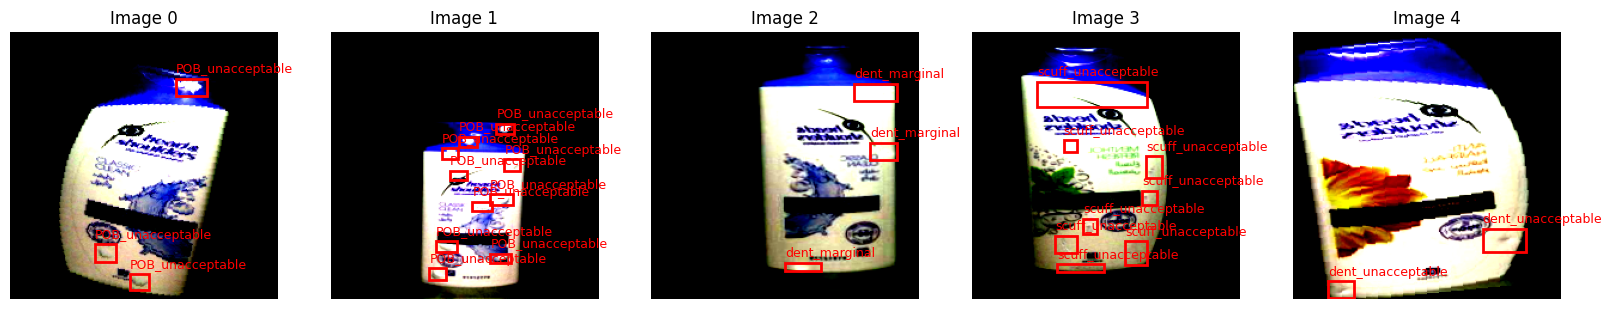

In [10]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F
from matplotlib import patches
from PIL import Image
import cv2

Tobeaugmented_dataset = CustomCocoDataset(
            root=train_dir,
            annotation_file=train_json,
            transforms=None,
            img_size=(224, 224),
            reduce_ratio=0.5
        )

        # Create augmentation instance
bbox_augment = BboxAugmentation(
            flip_prob=0.5,
            max_shift=0.1,
            max_rotate=15
        )

augmented_dataset = AugmentedDataset(Tobeaugmented_dataset, bbox_augment, transforms=transforms)

# Function to visualize a batch of images with bounding boxes and variable font sizes
def visualize_batch(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))

    for i in range(num_images):
        # Get image and target
        image, target = dataset[i]

        # Convert image to tensor if it's not already
        # Normalize image data to the range [0, 1] if it's a tensor
        if isinstance(image, torch.Tensor):
            image = image.permute(1, 2, 0).numpy()  # Convert tensor image to numpy format
            image = np.clip(image, 0, 1)  # Clip any values outside the range [0, 1]

        boxes = target["boxes"].numpy()
        labels = target["labels"].numpy()

        ax = axes[i]
        ax.imshow(image)
        ax.set_title(f"Image {i}")
        ax.axis("off")

        for box, label in zip(boxes, labels):
            xmin, ymin, xmax, ymax = box
            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

            # Apply font size based on class label
            class_name = IDX_TO_CLASS[label]  # Get the class name using label
            font_size = 9  # Default font size

            # Example: smaller font size for class 1, larger for others

            ax.text(xmin, ymin - 5, f"{class_name}", color='red', fontsize=font_size)

    plt.show()


# Visualize images from the training dataset
visualize_batch(augmented_dataset)


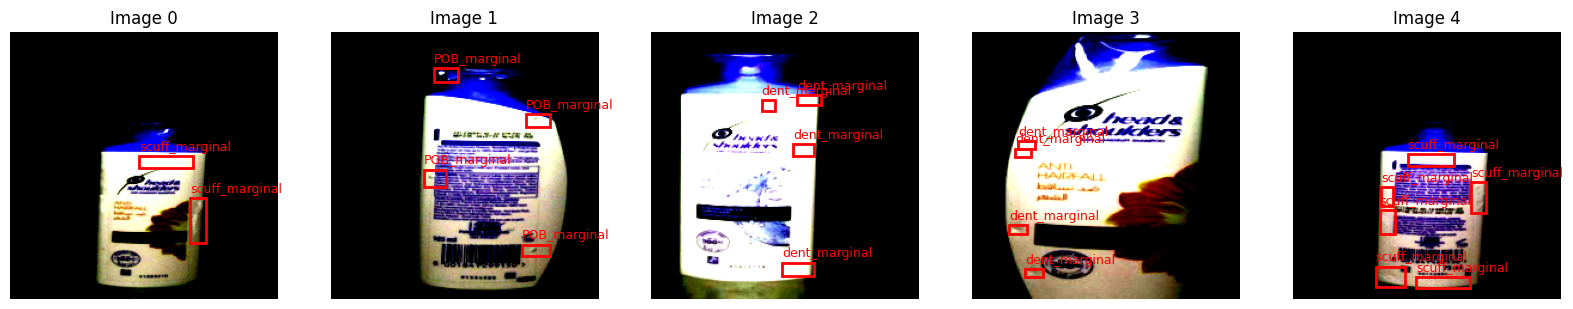

In [11]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F
from matplotlib import patches
from PIL import Image



# Function to visualize a batch of images with bounding boxes and variable font sizes
def visualize_batch(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))

    for i in range(num_images):
        # Get image and target
        image, target = dataset[i]

        # Convert image to tensor if it's not already
        # Normalize image data to the range [0, 1] if it's a tensor
        if isinstance(image, torch.Tensor):
            image = image.permute(1, 2, 0).numpy()  # Convert tensor image to numpy format
            image = np.clip(image, 0, 1)  # Clip any values outside the range [0, 1]

        boxes = target["boxes"].numpy()
        labels = target["labels"].numpy()

        ax = axes[i]
        ax.imshow(image)
        ax.set_title(f"Image {i}")
        ax.axis("off")

        for box, label in zip(boxes, labels):
            xmin, ymin, xmax, ymax = box
            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

            # Apply font size based on class label
            class_name = IDX_TO_CLASS[label]  # Get the class name using label
            font_size = 9  # Default font size

            # Example: smaller font size for class 1, larger for others

            ax.text(xmin, ymin - 5, f"{class_name}", color='red', fontsize=font_size)

    plt.show()

# Visualize images from the training dataset
visualize_batch(train_dataset)


# 3. Model Training

## Setting up the model and start Training

In [12]:
import torchvision
import torch.optim as optim

# Define the model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
in_features = model.roi_heads.box_predictor.cls_score.in_features
num_classes = len(CLASS_NAMES) + 1  # Number of classes + 1 for background
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 135MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 184MB/s]


Epoch [1/8], Step [1/286], Loss: 3.7985
Epoch [1/8], Step [2/286], Loss: 1.9695
Epoch [1/8], Step [3/286], Loss: 1.2453
Epoch [1/8], Step [4/286], Loss: 0.7424
Epoch [1/8], Step [5/286], Loss: 0.8834
Epoch [1/8], Step [6/286], Loss: 0.9645
Epoch [1/8], Step [7/286], Loss: 0.8084
Epoch [1/8], Step [8/286], Loss: 0.8935
Epoch [1/8], Step [9/286], Loss: 0.9758
Epoch [1/8], Step [10/286], Loss: 0.9612
Epoch [1/8], Step [11/286], Loss: 0.6932
Epoch [1/8], Step [12/286], Loss: 0.7410
Epoch [1/8], Step [13/286], Loss: 0.6349
Epoch [1/8], Step [14/286], Loss: 0.7281
Epoch [1/8], Step [15/286], Loss: 0.8955
Epoch [1/8], Step [16/286], Loss: 0.7161
Epoch [1/8], Step [17/286], Loss: 0.7010
Epoch [1/8], Step [18/286], Loss: 0.5599
Epoch [1/8], Step [19/286], Loss: 0.6265
Epoch [1/8], Step [20/286], Loss: 0.7874
Epoch [1/8], Step [21/286], Loss: 0.7721
Epoch [1/8], Step [22/286], Loss: 0.9583
Epoch [1/8], Step [23/286], Loss: 0.9150
Epoch [1/8], Step [24/286], Loss: 0.9893
Epoch [1/8], Step [25/286

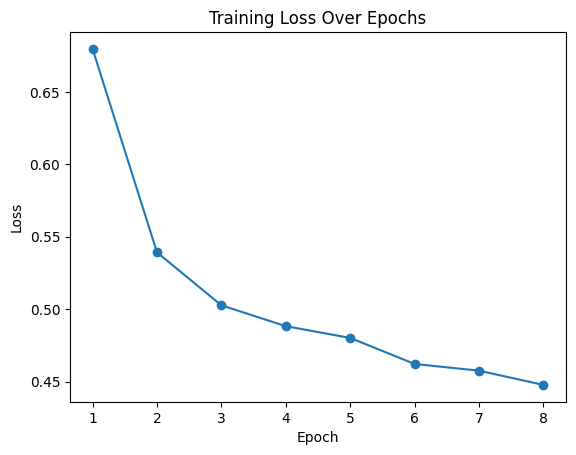

In [ ]:
# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop with loss visualization
num_epochs = 8
train_losses = []
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, targets) in enumerate(train_loader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        optimizer.zero_grad()
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] Completed, Average Loss: {epoch_loss:.4f}\n")

# Plot training loss
plt.plot(range(1, num_epochs+1), train_losses, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

# Save the CheckPoint afterwards

In [ ]:
import torch
from datetime import datetime

# Get current timestamp
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")  # Format: YYYY-MM-DD_HH-MM-SS

# Save model checkpoint with timestamp
###################CHANGE TO YOUR MODEL NAME##############################

checkpoint_filename = f"{current_time}_fasterrcnn_epoch_{epoch+1}.pth"

###################CHANGE TO YOUR MODEL NAME##############################

torch.save(model.state_dict(), checkpoint_filename)

print(f"Model saved as {checkpoint_filename}")


Model saved as 2025-04-03_05-56-44_fasterrcnn_epoch_8.pth


# 4. Load the Model adn Evaluate

In [13]:
# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None)  # No default weights
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Load the saved weights
###################CHANGE TO YOUR CHECKPOINT PATH##############################

checkpoint_path = "/content/2025-04-03_05-56-44_fasterrcnn_epoch_8.pth"  # Update with your checkpoint file name

###################CHANGE TO YOUR CHECKPOINT PATH##############################

model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.to(device)
model.eval()  # Set to evaluation mode

print("Model loaded successfully!")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 187MB/s]


Model loaded successfully!


In [16]:
!pip install torchmetrics
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from torchmetrics.detection import MeanAveragePrecision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

# 5. Evaluating Model + Visualizing the Results

## For preventing Overlapping BBOX prediction

In [ ]:
def apply_nms(prediction, iou_threshold=0.5):
    """
    Apply Non-Maximum Suppression to avoid overlapping boxes
    """
    keep_indices = torchvision.ops.nms(
        boxes=prediction['boxes'],
        scores=prediction['scores'],
        iou_threshold=iou_threshold
    )
    return {
        'boxes': prediction['boxes'][keep_indices],
        'scores': prediction['scores'][keep_indices],
        'labels': prediction['labels'][keep_indices]
    }

In [17]:
def evaluate_model(model, dataloader, device, class_names):
    """
    Evaluate the model with NMS and return metrics
    """
    model.eval()
    metric = MeanAveragePrecision(class_metrics=True)

    with torch.no_grad():
        for images, targets in dataloader:
            images = list(image.to(device) for image in images)
            outputs = model(images)

            preds = []
            gts = []

            for i in range(len(outputs)):
                # Apply NMS to each prediction
                nms_output = apply_nms(outputs[i])

                pred_boxes = nms_output['boxes'].cpu()
                pred_scores = nms_output['scores'].cpu()
                pred_labels = nms_output['labels'].cpu()

                gt_boxes = targets[i]['boxes'].cpu()
                gt_labels = targets[i]['labels'].cpu()

                preds.append({
                    'boxes': pred_boxes,
                    'scores': pred_scores,
                    'labels': pred_labels
                })

                gts.append({
                    'boxes': gt_boxes,
                    'labels': gt_labels
                })

            metric.update(preds, gts)

    results = metric.compute()

    print("\nClass-wise Average Precision:")
    for i, class_name in enumerate(class_names[1:]):  # Skip background class
        print(f"{class_name}: {results['map_per_class'][i].item():.4f}")

    print(f"\nmAP@0.50: {results['map_50'].item():.4f}")
    print(f"mAP@0.50:0.95: {results['map'].item():.4f}")

    return results

In [18]:
def plot_metrics(metrics, class_names):
    """
    Plot evaluation metrics (excluding background class)
    """
    # Extract relevant metrics
    map_per_class = metrics['map_per_class'].cpu().numpy()
    mar_per_class = metrics['mar_100_per_class'].cpu().numpy()

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Plot mAP per class
    axes[0].bar(class_names[1:], map_per_class)
    axes[0].set_title('mAP per Class')
    axes[0].set_ylim(0, 1)
    axes[0].set_ylabel('Average Precision')

    # Plot mAR per class
    axes[1].bar(class_names[1:], mar_per_class)
    axes[1].set_title('mAR per Class')
    axes[1].set_ylim(0, 1)
    axes[1].set_ylabel('Average Recall')

    # Plot precision-recall curve (example for first class)
    if 'precision' in metrics and 'recall' in metrics:
        precision = metrics['precision'].cpu().numpy()
        recall = metrics['recall'].cpu().numpy()
        axes[2].plot(recall, precision)
        axes[2].set_title('Precision-Recall Curve')
        axes[2].set_xlabel('Recall')
        axes[2].set_ylabel('Precision')
        axes[2].set_xlim(0, 1)
        axes[2].set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

In [19]:
def visualize_predictions(model, dataset, device, class_names, num_images=4, confidence_threshold=0.5):
    """
    Visualize predictions with NMS applied
    """
    model.eval()
    indices = np.random.choice(len(dataset), num_images)

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()

    for i, idx in enumerate(indices):
        image, target = dataset[idx]
        image_tensor = image.unsqueeze(0).to(device)

        with torch.no_grad():
            prediction = model(image_tensor)[0]
            # Apply NMS to prediction
            prediction = apply_nms(prediction)

        # Convert image to numpy and denormalize
        image = image.permute(1, 2, 0).cpu().numpy()
        image = (image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))
        image = np.clip(image, 0, 1)

        # Plot ground truth
        axes[i].imshow(image)
        for box, label in zip(target['boxes'], target['labels']):
            x1, y1, x2, y2 = box
            rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                fill=False, color='green', linewidth=2)
            axes[i].add_patch(rect)
            axes[i].text(x1, y1, f'GT: {class_names[label]}',
                        color='green', fontsize=8,
                        bbox=dict(facecolor='white', alpha=0.7))

        # Plot predictions with confidence threshold
        for box, score, label in zip(prediction['boxes'], prediction['scores'], prediction['labels']):
            if score > confidence_threshold:
                box = box.cpu().numpy()
                x1, y1, x2, y2 = box
                rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                    fill=False, color='red', linewidth=2)
                axes[i].add_patch(rect)
                axes[i].text(x1, y1-10, f'{class_names[label]}: {score:.2f}',
                            color='red', fontsize=8,
                            bbox=dict(facecolor='white', alpha=0.7))

        axes[i].axis('off')
        axes[i].set_title(f'Image {idx}')

    plt.tight_layout()
    plt.show()

In [20]:
def analyze_errors(model, dataloader, device, class_names, iou_threshold=0.5, confidence_threshold=0.5):
    """
    Analyze errors with NMS applied
    """
    false_positives = defaultdict(int)
    false_negatives = defaultdict(int)

    with torch.no_grad():
        for images, targets in dataloader:
            images = list(image.to(device) for image in images)
            outputs = model(images)

            for i in range(len(outputs)):
                # Apply NMS to predictions
                nms_output = apply_nms(outputs[i])

                pred_boxes = nms_output['boxes'].cpu()
                pred_labels = nms_output['labels'].cpu()
                pred_scores = nms_output['scores'].cpu()

                gt_boxes = targets[i]['boxes'].cpu()
                gt_labels = targets[i]['labels'].cpu()

                # Calculate IoU between predictions and ground truths
                iou_matrix = torchvision.ops.box_iou(pred_boxes, gt_boxes)

                # Find matches
                matched_preds = set()
                matched_gts = set()

                for pred_idx in range(len(pred_boxes)):
                    for gt_idx in range(len(gt_boxes)):
                        if iou_matrix[pred_idx, gt_idx] > iou_threshold:
                            matched_preds.add(pred_idx)
                            matched_gts.add(gt_idx)

                # Count false positives (high confidence predictions not matched to any GT)
                for pred_idx in range(len(pred_boxes)):
                    if (pred_idx not in matched_preds and
                        pred_scores[pred_idx] > confidence_threshold):
                        false_positives[class_names[pred_labels[pred_idx]]] += 1

                # Count false negatives (GTs not matched to any prediction)
                for gt_idx in range(len(gt_boxes)):
                    if gt_idx not in matched_gts:
                        false_negatives[class_names[gt_labels[gt_idx]]] += 1

    # Plot error analysis
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # False positives
    ax1.bar(false_positives.keys(), false_positives.values())
    ax1.set_title('False Positives by Class')
    ax1.set_ylabel('Count')
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

    # False negatives
    ax2.bar(false_negatives.keys(), false_negatives.values())
    ax2.set_title('False Negatives by Class')
    ax2.set_ylabel('Count')
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

In [ ]:
# After defining all the functions above, you can run:

# 1. Evaluate the model
val_results = evaluate_model(model, valid_loader, device, CLASS_NAMES)



In [ ]:
# 2. Plot metrics
plot_metrics(val_results, CLASS_NAMES)



In [ ]:
# 3. Visualize predictions
visualize_predictions(model, valid_dataset, device, CLASS_NAMES)



In [ ]:
# 4. Analyze errors
analyze_errors(model, valid_loader, device, CLASS_NAMES)